In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

# 1. Device Configuration for Apple Silicon

In [ ]:
print("Configuring device for Apple Silicon...")

if tf.config.list_physical_devices('GPU'):
    print("MPS (Metal Performance Shaders) available")
    try:
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        print("GPU memory growth enabled")
    except:
        print("GPU memory growth could not be enabled")
    device = "/GPU:0"  
    print("Using Apple Silicon GPU (MPS)")
else:
    print("GPU not available, using CPU")
    device = "/CPU:0"

# Alretnatively
try:
    if hasattr(tf.config.experimental, 'list_physical_devices'):
        mps_devices = tf.config.experimental.list_physical_devices('GPU')
        if mps_devices:
            print(f"MPS devices found: {mps_devices}")
        else:
            print("No MPS devices found")
except:
    print("Could not check MPS availability")

print(f"TensorFlow version: {tf.__version__}")
print(f"Using device: {device}")

print("\nAvailable devices:")
for device_info in tf.config.list_physical_devices():
    print(f"  {device_info}")

# 2. Download Dataset using kagglehub and Setup Paths

In [ ]:
print("\nDownloading dataset from Kaggle Hub...")

base_kaggle_path = kagglehub.dataset_download("aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented")
print(f"Dataset downloaded to: {base_kaggle_path}")

LOCAL_DATASET_PATH = os.path.join(base_kaggle_path, 'combined_images')
print(f"Corrected path to classes: {LOCAL_DATASET_PATH}")

# Image and model parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001


# 3. Create a DataFrame to Manage Local File Paths

In [ ]:
image_paths = []
labels = []

class_names = os.listdir(LOCAL_DATASET_PATH)
print(f"\nClasses found: {class_names}")

for class_name in class_names:
    class_path = os.path.join(LOCAL_DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)

df = pd.DataFrame({'filepath': image_paths, 'label': labels})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTraining set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Classes distribution
print("\nClass distribution in training set:")
print(train_df['label'].value_counts())
NUM_CLASSES = len(train_df['label'].unique())
print(f"Number of classes: {NUM_CLASSES}")


# 4. Data Generators

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


# 5. Model Architecture

In [ ]:
print("\nBuilding the enhanced multiclass model...")

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # First block of convolutions
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Second block of convolutions
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Тhird block of convolutions
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Fourth block of convolutions
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Flattening and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
top_k_accuracy = TopKCategoricalAccuracy(k=min(3, NUM_CLASSES), name='top_k_categorical_accuracy')

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', top_k_accuracy]
)

model.summary()

# 6. Callbacks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_alzheimer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

# 7. Model Training

In [ ]:
print("\nStarting enhanced model training...")
print("Training will use Apple Silicon GPU (MPS) if available...")

# Device check and training
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    print(f"Training device: {tf.config.list_physical_devices('GPU')[0] if tf.config.list_physical_devices('GPU') else 'CPU'}")
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

# 8. Load Best Model and Evaluate

In [ ]:
print("\nLoading best model for evaluation...")
model.load_weights('best_alzheimer_model.h5')

print("\nEvaluating the model on the test data...")
test_results = model.evaluate(test_generator, verbose=1)

test_loss = test_results[0]
test_accuracy = test_results[1]
test_top_k_accuracy = test_results[2] if len(test_results) > 2 else None

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
if test_top_k_accuracy is not None:
    print(f"Test Top-K Accuracy: {test_top_k_accuracy:.4f}")

# 9. Predictions and Analysis

In [ ]:
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
prediction_probabilities = np.max(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print(f"\nPrediction confidence statistics:")
print(f"Mean confidence: {np.mean(prediction_probabilities):.4f}")
print(f"Std confidence: {np.std(prediction_probabilities):.4f}")
print(f"Min confidence: {np.min(prediction_probabilities):.4f}")
print(f"Max confidence: {np.max(prediction_probabilities):.4f}")


# 10. Visualizations

Configuring device for Apple Silicon...
MPS (Metal Performance Shaders) available
GPU memory growth could not be enabled
Using Apple Silicon GPU (MPS)
MPS devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0
Using device: /GPU:0

Available devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Dataset downloaded to: /Users/alexmolin/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1
Corrected path to classes: /Users/alexmolin/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1/combined_images

Classes found: ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']

Training set size: 35200
Test set size: 8800

Class distribution in training set:
label
NonDemented         10240
VeryMildDemented     8960
ModerateDemented     8000
M

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,108,644 (34.75 MB)

 Trainable params: 9,106,148 (34.74 MB)

 Non-trainable params: 2,496 (9.75 KB)


Starting enhanced model training...
Training will use Apple Silicon GPU (MPS) if available...
Training device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/50


/Users/alexmolin/dsdm/applications_of_deep_learning/final_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3250 - loss: 1.7593 - top_k_categorical_accuracy: 0.8070
Epoch 1: val_accuracy improved from -inf to 0.28835, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 125s 136ms/step - accuracy: 0.3251 - loss: 1.7590 - top_k_categorical_accuracy: 0.8070 - val_accuracy: 0.2884 - val_loss: 2.2645 - val_top_k_categorical_accuracy: 0.7749 - learning_rate: 0.0010
Epoch 2/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4222 - loss: 1.2193 - top_k_categorical_accuracy: 0.8915
Epoch 2: val_accuracy improved from 0.28835 to 0.29347, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 135s 154ms/step - accuracy: 0.4222 - loss: 1.2192 - top_k_categorical_accuracy: 0.8915 - val_accuracy: 0.2935 - val_loss: 1.8957 - val_top_k_categorical_accuracy: 0.7786 - learning_rate: 0.0010
Epoch 3/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4995 - loss: 1.0917 - top_k_categorical_accuracy: 0.9385
Epoch 3: val_accuracy improved from 0.29347 to 0.32031, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 119s 135ms/step - accuracy: 0.4995 - loss: 1.0917 - top_k_categorical_accuracy: 0.9385 - val_accuracy: 0.3203 - val_loss: 1.8171 - val_top_k_categorical_accuracy: 0.8509 - learning_rate: 0.0010
Epoch 4/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5573 - loss: 0.9659 - top_k_categorical_accuracy: 0.9604
Epoch 4: val_accuracy improved from 0.32031 to 0.41903, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 118s 134ms/step - accuracy: 0.5573 - loss: 0.9658 - top_k_categorical_accuracy: 0.9604 - val_accuracy: 0.4190 - val_loss: 1.1928 - val_top_k_categorical_accuracy: 0.9520 - learning_rate: 0.0010
Epoch 5/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6033 - loss: 0.8572 - top_k_categorical_accuracy: 0.9801
Epoch 5: val_accuracy improved from 0.41903 to 0.43310, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 117s 133ms/step - accuracy: 0.6033 - loss: 0.8572 - top_k_categorical_accuracy: 0.9801 - val_accuracy: 0.4331 - val_loss: 1.2721 - val_top_k_categorical_accuracy: 0.8825 - learning_rate: 0.0010
Epoch 6/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6205 - loss: 0.7999 - top_k_categorical_accuracy: 0.9868
Epoch 6: val_accuracy improved from 0.43310 to 0.65866, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 1157s 1s/step - accuracy: 0.6205 - loss: 0.7999 - top_k_categorical_accuracy: 0.9868 - val_accuracy: 0.6587 - val_loss: 0.7117 - val_top_k_categorical_accuracy: 0.9946 - learning_rate: 0.0010
Epoch 7/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6383 - loss: 0.7602 - top_k_categorical_accuracy: 0.9909
Epoch 7: val_accuracy did not improve from 0.65866
880/880 ━━━━━━━━━━━━━━━━━━━━ 123s 140ms/step - accuracy: 0.6383 - loss: 0.7601 - top_k_categorical_accuracy: 0.9909 - val_accuracy: 0.5876 - val_loss: 0.9740 - val_top_k_categorical_accuracy: 0.9838 - learning_rate: 0.0010
Epoch 8/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6557 - loss: 0.7337 - top_k_categorical_accuracy: 0.9920
Epoch 8: val_accuracy improved from 0.65866 to 0.66080, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 117s 132ms/step - accuracy: 0.6557 - loss: 0.7337 - top_k_categorical_accuracy: 0.9920 - val_accuracy: 0.6608 - val_loss: 0.7346 - val_top_k_categorical_accuracy: 0.9966 - learning_rate: 0.0010
Epoch 9/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6692 - loss: 0.7014 - top_k_categorical_accuracy: 0.9936
Epoch 9: val_accuracy improved from 0.66080 to 0.69205, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 116s 131ms/step - accuracy: 0.6692 - loss: 0.7014 - top_k_categorical_accuracy: 0.9936 - val_accuracy: 0.6920 - val_loss: 0.6520 - val_top_k_categorical_accuracy: 0.9976 - learning_rate: 0.0010
Epoch 10/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6750 - loss: 0.6962 - top_k_categorical_accuracy: 0.9926
Epoch 10: val_accuracy did not improve from 0.69205
880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.6750 - loss: 0.6962 - top_k_categorical_accuracy: 0.9926 - val_accuracy: 0.5351 - val_loss: 1.0695 - val_top_k_categorical_accuracy: 0.9794 - learning_rate: 0.0010
Epoch 11/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6815 - loss: 0.6846 - top_k_categorical_accuracy: 0.9935
Epoch 11: val_accuracy did not improve from 0.69205
880/880 ━━━━━━━━━━━━━━━━━━━━ 125s 142ms/step - accuracy: 0.6815 - loss: 0.6846 - top_k_categorical_accuracy: 0.9935 - val_accuracy: 0.6822 - val_loss: 0.6636 - val_top_k_categorical_accuracy: 0.9984

880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.7079 - loss: 0.6432 - top_k_categorical_accuracy: 0.9957 - val_accuracy: 0.7097 - val_loss: 0.6695 - val_top_k_categorical_accuracy: 0.9878 - learning_rate: 0.0010
Epoch 14/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7223 - loss: 0.6242 - top_k_categorical_accuracy: 0.9953
Epoch 14: val_accuracy improved from 0.70966 to 0.71435, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.7223 - loss: 0.6242 - top_k_categorical_accuracy: 0.9953 - val_accuracy: 0.7143 - val_loss: 0.6383 - val_top_k_categorical_accuracy: 0.9986 - learning_rate: 0.0010
Epoch 15/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7271 - loss: 0.6127 - top_k_categorical_accuracy: 0.9960
Epoch 15: val_accuracy improved from 0.71435 to 0.73693, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 117s 133ms/step - accuracy: 0.7271 - loss: 0.6127 - top_k_categorical_accuracy: 0.9960 - val_accuracy: 0.7369 - val_loss: 0.6056 - val_top_k_categorical_accuracy: 0.9977 - learning_rate: 0.0010
Epoch 16/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7284 - loss: 0.6174 - top_k_categorical_accuracy: 0.9959
Epoch 16: val_accuracy improved from 0.73693 to 0.77273, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 117s 133ms/step - accuracy: 0.7284 - loss: 0.6174 - top_k_categorical_accuracy: 0.9959 - val_accuracy: 0.7727 - val_loss: 0.5088 - val_top_k_categorical_accuracy: 0.9994 - learning_rate: 0.0010
Epoch 17/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7426 - loss: 0.5850 - top_k_categorical_accuracy: 0.9964
Epoch 17: val_accuracy did not improve from 0.77273
880/880 ━━━━━━━━━━━━━━━━━━━━ 118s 133ms/step - accuracy: 0.7426 - loss: 0.5850 - top_k_categorical_accuracy: 0.9964 - val_accuracy: 0.7477 - val_loss: 0.5797 - val_top_k_categorical_accuracy: 0.9947 - learning_rate: 0.0010
Epoch 18/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7460 - loss: 0.5754 - top_k_categorical_accuracy: 0.9960
Epoch 18: val_accuracy improved from 0.77273 to 0.77443, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 118s 134ms/step - accuracy: 0.7460 - loss: 0.5754 - top_k_categorical_accuracy: 0.9960 - val_accuracy: 0.7744 - val_loss: 0.5391 - val_top_k_categorical_accuracy: 0.9972 - learning_rate: 0.0010
Epoch 19/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7519 - loss: 0.5727 - top_k_categorical_accuracy: 0.9955
Epoch 19: val_accuracy did not improve from 0.77443
880/880 ━━━━━━━━━━━━━━━━━━━━ 119s 135ms/step - accuracy: 0.7519 - loss: 0.5727 - top_k_categorical_accuracy: 0.9955 - val_accuracy: 0.7332 - val_loss: 0.5754 - val_top_k_categorical_accuracy: 0.9994 - learning_rate: 0.0010
Epoch 20/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7594 - loss: 0.5471 - top_k_categorical_accuracy: 0.9980
Epoch 20: val_accuracy improved from 0.77443 to 0.80398, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 119s 135ms/step - accuracy: 0.7594 - loss: 0.5471 - top_k_categorical_accuracy: 0.9980 - val_accuracy: 0.8040 - val_loss: 0.4689 - val_top_k_categorical_accuracy: 0.9989 - learning_rate: 0.0010
Epoch 21/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7676 - loss: 0.5516 - top_k_categorical_accuracy: 0.9963
Epoch 21: val_accuracy did not improve from 0.80398
880/880 ━━━━━━━━━━━━━━━━━━━━ 118s 134ms/step - accuracy: 0.7676 - loss: 0.5516 - top_k_categorical_accuracy: 0.9963 - val_accuracy: 0.8034 - val_loss: 0.4535 - val_top_k_categorical_accuracy: 0.9990 - learning_rate: 0.0010
Epoch 22/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7727 - loss: 0.5297 - top_k_categorical_accuracy: 0.9975
Epoch 22: val_accuracy did not improve from 0.80398
880/880 ━━━━━━━━━━━━━━━━━━━━ 119s 135ms/step - accuracy: 0.7728 - loss: 0.5297 - top_k_categorical_accuracy: 0.9975 - val_accuracy: 0.7720 - val_loss: 0.5306 - val_top_k_categorical_accuracy: 0.9939

880/880 ━━━━━━━━━━━━━━━━━━━━ 120s 136ms/step - accuracy: 0.8097 - loss: 0.4693 - top_k_categorical_accuracy: 0.9967 - val_accuracy: 0.8575 - val_loss: 0.3536 - val_top_k_categorical_accuracy: 0.9999 - learning_rate: 2.0000e-04
Epoch 28/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8223 - loss: 0.4426 - top_k_categorical_accuracy: 0.9978
Epoch 28: val_accuracy improved from 0.85753 to 0.87187, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 119s 136ms/step - accuracy: 0.8223 - loss: 0.4426 - top_k_categorical_accuracy: 0.9978 - val_accuracy: 0.8719 - val_loss: 0.3354 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 29/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8261 - loss: 0.4324 - top_k_categorical_accuracy: 0.9982
Epoch 29: val_accuracy did not improve from 0.87187
880/880 ━━━━━━━━━━━━━━━━━━━━ 120s 136ms/step - accuracy: 0.8261 - loss: 0.4324 - top_k_categorical_accuracy: 0.9982 - val_accuracy: 0.8696 - val_loss: 0.3331 - val_top_k_categorical_accuracy: 0.9997 - learning_rate: 2.0000e-04
Epoch 30/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8232 - loss: 0.4297 - top_k_categorical_accuracy: 0.9981
Epoch 30: val_accuracy improved from 0.87187 to 0.87528, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 120s 137ms/step - accuracy: 0.8232 - loss: 0.4297 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.8753 - val_loss: 0.3235 - val_top_k_categorical_accuracy: 0.9997 - learning_rate: 2.0000e-04
Epoch 31/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8289 - loss: 0.4184 - top_k_categorical_accuracy: 0.9979
Epoch 31: val_accuracy improved from 0.87528 to 0.87741, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 120s 136ms/step - accuracy: 0.8289 - loss: 0.4184 - top_k_categorical_accuracy: 0.9979 - val_accuracy: 0.8774 - val_loss: 0.3245 - val_top_k_categorical_accuracy: 0.9994 - learning_rate: 2.0000e-04
Epoch 32/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8283 - loss: 0.4250 - top_k_categorical_accuracy: 0.9979
Epoch 32: val_accuracy did not improve from 0.87741
880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.8283 - loss: 0.4250 - top_k_categorical_accuracy: 0.9979 - val_accuracy: 0.8774 - val_loss: 0.3209 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 33/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8331 - loss: 0.4124 - top_k_categorical_accuracy: 0.9981
Epoch 33: val_accuracy did not improve from 0.87741
880/880 ━━━━━━━━━━━━━━━━━━━━ 120s 136ms/step - accuracy: 0.8331 - loss: 0.4124 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.8751 - val_loss: 0.3196 - val_top_k_categorical_accuracy

880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.8401 - loss: 0.3990 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.8852 - val_loss: 0.3031 - val_top_k_categorical_accuracy: 0.9996 - learning_rate: 2.0000e-04
Epoch 35/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8320 - loss: 0.4111 - top_k_categorical_accuracy: 0.9981
Epoch 35: val_accuracy did not improve from 0.88523
880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.8320 - loss: 0.4111 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.8847 - val_loss: 0.2930 - val_top_k_categorical_accuracy: 0.9997 - learning_rate: 2.0000e-04
Epoch 36/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8423 - loss: 0.3978 - top_k_categorical_accuracy: 0.9989
Epoch 36: val_accuracy improved from 0.88523 to 0.89347, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 138ms/step - accuracy: 0.8423 - loss: 0.3978 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.8935 - val_loss: 0.2885 - val_top_k_categorical_accuracy: 0.9996 - learning_rate: 2.0000e-04
Epoch 37/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8456 - loss: 0.3923 - top_k_categorical_accuracy: 0.9985
Epoch 37: val_accuracy did not improve from 0.89347
880/880 ━━━━━━━━━━━━━━━━━━━━ 122s 139ms/step - accuracy: 0.8456 - loss: 0.3923 - top_k_categorical_accuracy: 0.9985 - val_accuracy: 0.8886 - val_loss: 0.2947 - val_top_k_categorical_accuracy: 0.9997 - learning_rate: 2.0000e-04
Epoch 38/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8448 - loss: 0.3919 - top_k_categorical_accuracy: 0.9982
Epoch 38: val_accuracy did not improve from 0.89347
880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.8448 - loss: 0.3919 - top_k_categorical_accuracy: 0.9982 - val_accuracy: 0.8932 - val_loss: 0.2787 - val_top_k_categorical_accuracy

880/880 ━━━━━━━━━━━━━━━━━━━━ 122s 138ms/step - accuracy: 0.8480 - loss: 0.3795 - top_k_categorical_accuracy: 0.9986 - val_accuracy: 0.8960 - val_loss: 0.2828 - val_top_k_categorical_accuracy: 0.9999 - learning_rate: 2.0000e-04
Epoch 41/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8499 - loss: 0.3827 - top_k_categorical_accuracy: 0.9988
Epoch 41: val_accuracy did not improve from 0.89602
880/880 ━━━━━━━━━━━━━━━━━━━━ 122s 139ms/step - accuracy: 0.8499 - loss: 0.3827 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.8911 - val_loss: 0.2814 - val_top_k_categorical_accuracy: 0.9994 - learning_rate: 2.0000e-04
Epoch 42/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8499 - loss: 0.3795 - top_k_categorical_accuracy: 0.9977
Epoch 42: val_accuracy did not improve from 0.89602
880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 138ms/step - accuracy: 0.8499 - loss: 0.3795 - top_k_categorical_accuracy: 0.9977 - val_accuracy: 0.8926 - val_loss: 0.2862 - val_top_k_categorical_accuracy

880/880 ━━━━━━━━━━━━━━━━━━━━ 122s 138ms/step - accuracy: 0.8546 - loss: 0.3706 - top_k_categorical_accuracy: 0.9976 - val_accuracy: 0.8987 - val_loss: 0.2644 - val_top_k_categorical_accuracy: 0.9997 - learning_rate: 4.0000e-05
Epoch 45/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8615 - loss: 0.3554 - top_k_categorical_accuracy: 0.9986
Epoch 45: val_accuracy improved from 0.89872 to 0.90625, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 122s 138ms/step - accuracy: 0.8615 - loss: 0.3554 - top_k_categorical_accuracy: 0.9986 - val_accuracy: 0.9062 - val_loss: 0.2565 - val_top_k_categorical_accuracy: 0.9999 - learning_rate: 4.0000e-05
Epoch 46/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8561 - loss: 0.3692 - top_k_categorical_accuracy: 0.9987
Epoch 46: val_accuracy improved from 0.90625 to 0.90838, saving model to best_alzheimer_model.h5


880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 138ms/step - accuracy: 0.8561 - loss: 0.3692 - top_k_categorical_accuracy: 0.9987 - val_accuracy: 0.9084 - val_loss: 0.2569 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.0000e-05
Epoch 47/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8575 - loss: 0.3620 - top_k_categorical_accuracy: 0.9991
Epoch 47: val_accuracy did not improve from 0.90838
880/880 ━━━━━━━━━━━━━━━━━━━━ 121s 137ms/step - accuracy: 0.8575 - loss: 0.3620 - top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.9065 - val_loss: 0.2495 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.0000e-05
Epoch 48/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8605 - loss: 0.3548 - top_k_categorical_accuracy: 0.9982
Epoch 48: val_accuracy did not improve from 0.90838
880/880 ━━━━━━━━━━━━━━━━━━━━ 122s 138ms/step - accuracy: 0.8605 - loss: 0.3549 - top_k_categorical_accuracy: 0.9982 - val_accuracy: 0.9043 - val_loss: 0.2522 - val_top_k_categorical_accuracy

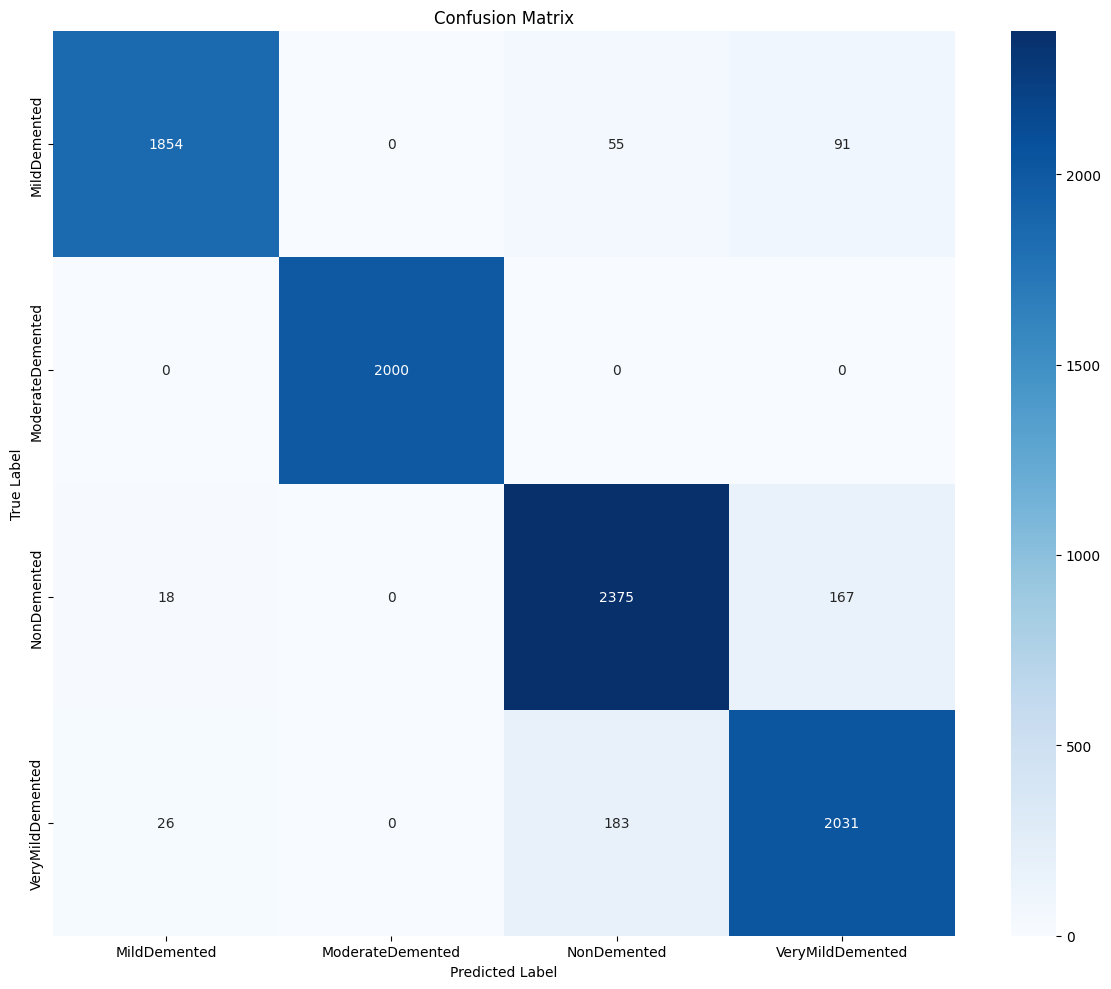

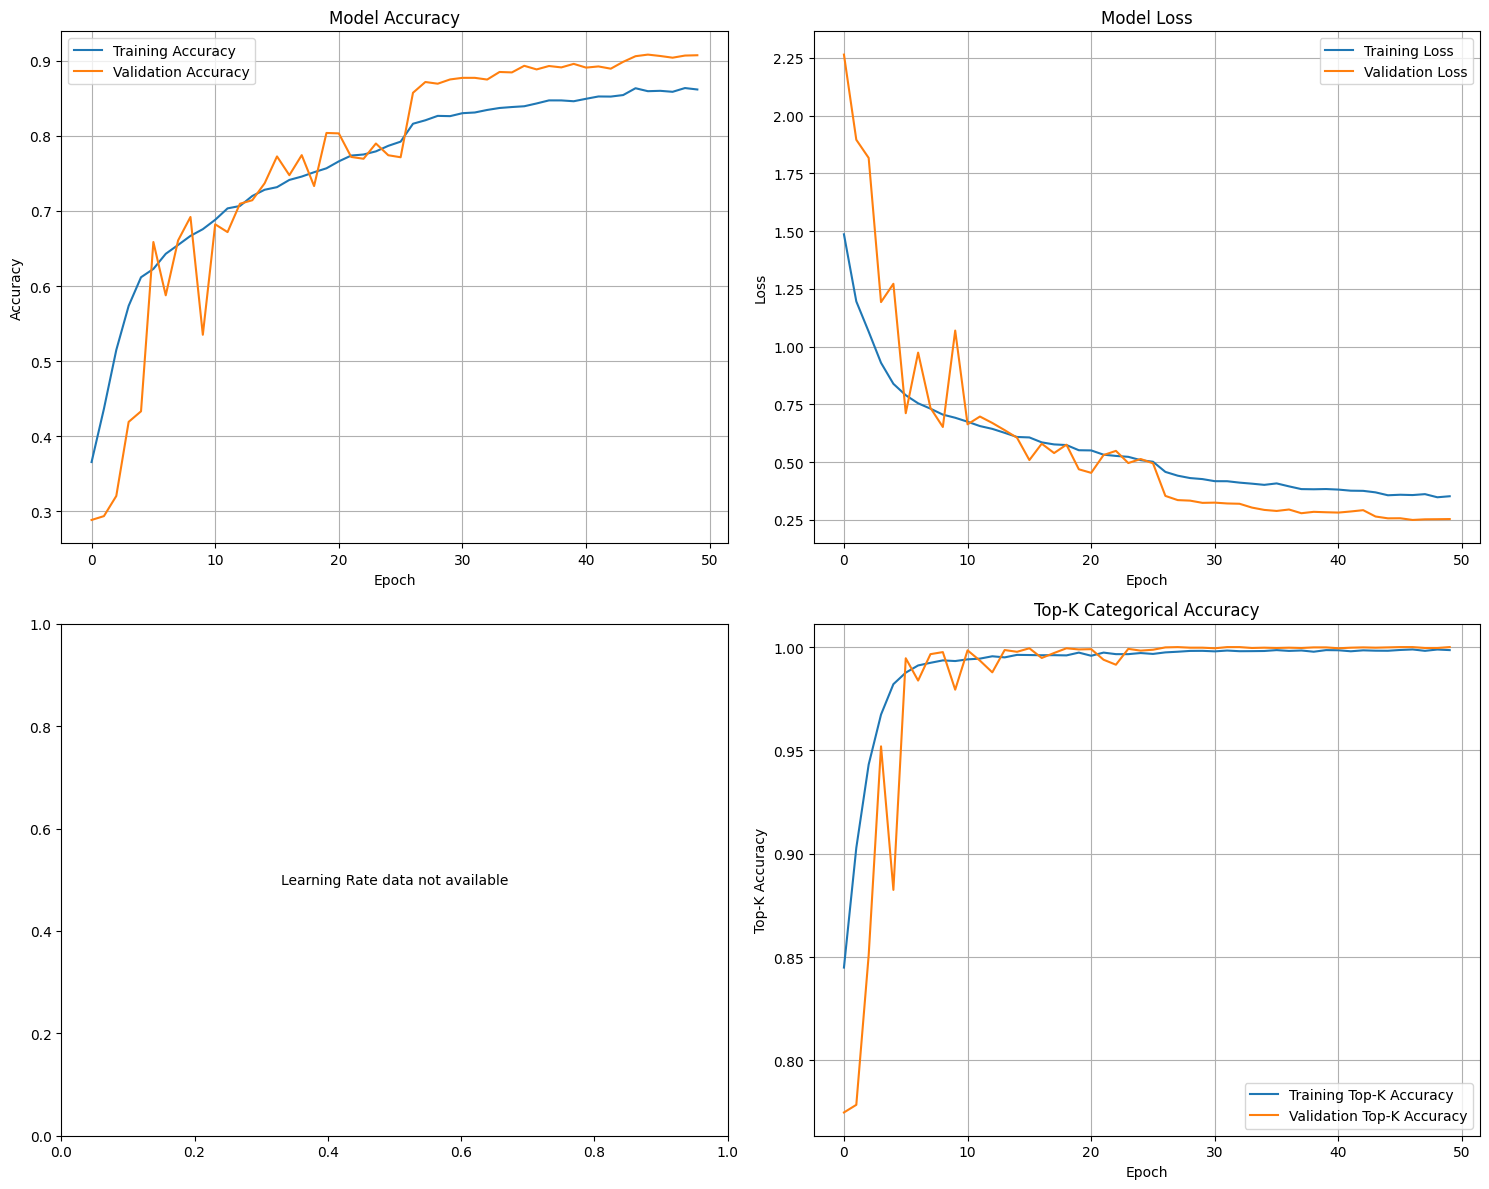

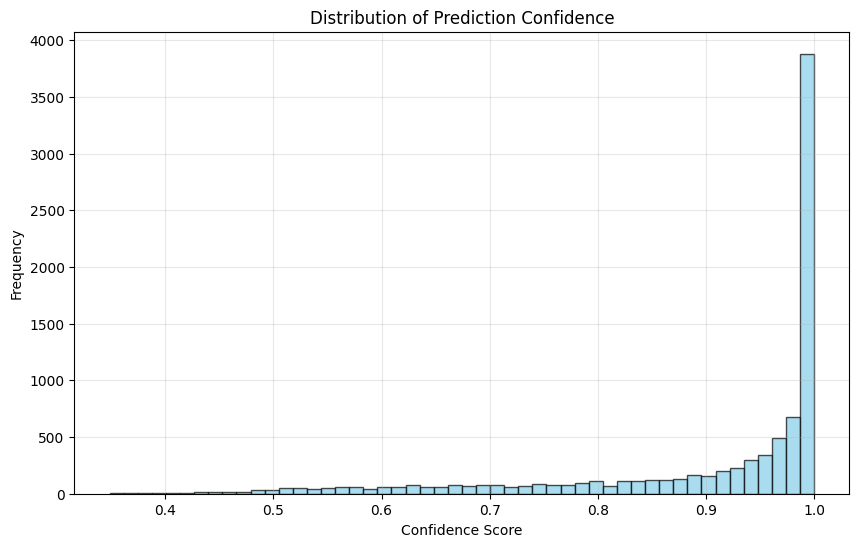


Training completed successfully!
Best model saved as 'best_alzheimer_model.h5'

Device information:
TensorFlow built with MPS support: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning Rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'])
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning Rate data not available', 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=axes[1, 0].transAxes)

# Top-K Accuracy
if 'top_k_categorical_accuracy' in history.history:
    axes[1, 1].plot(history.history['top_k_categorical_accuracy'], label='Training Top-K Accuracy')
    axes[1, 1].plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-K Accuracy')
    axes[1, 1].set_title('Top-K Categorical Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Top-K Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
else:
    axes[1, 1].text(0.5, 0.5, 'Top-K Accuracy data not available', 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

# Distribution of Prediction Confidence
plt.figure(figsize=(10, 6))
plt.hist(prediction_probabilities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print("\nTraining completed successfully!")
print(f"Best model saved as 'best_alzheimer_model.h5'")

print(f"\nDevice information:")
print(f"TensorFlow built with MPS support: {tf.config.list_physical_devices('GPU')}")